https://kedro.readthedocs.io/en/stable/12_faq/01_faq.html#what-is-data-engineering-convention

In [1]:
import numpy as np
import pandas as pd

from pandas.tseries.offsets import Week


In [50]:
%reload_kedro

2021-03-28 22:07:31,833 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2021-03-28 22:07:31,984 - root - INFO - ** Kedro project xflats
2021-03-28 22:07:31,986 - root - INFO - Defined global variable `context`, `session` and `catalog`
2021-03-28 22:07:32,017 - root - INFO - Registered line magic `run_viz`


In [3]:
df = catalog.load('preprocessed_flats')
df_aggr = catalog.load('aggregate_avg_flats_prices')

2021-03-28 20:43:19,153 - kedro.io.data_catalog - INFO - Loading data from `preprocessed_flats` (ParquetDataSet)...
2021-03-28 20:43:21,645 - kedro.io.data_catalog - INFO - Loading data from `aggregate_avg_flats_prices` (ParquetDataSet)...


In [4]:
df['date_offer_d'] = df.date_offer.dt.floor("D")
df['date_offer_w'] = df['date_offer_d'] + Week(weekday=6)
df = df.merge(df_aggr, how='left', on=['GC_addr_suburb','market','date_offer_w'])

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.ticker import FuncFormatter


In [10]:
df.shape

(166941, 50)

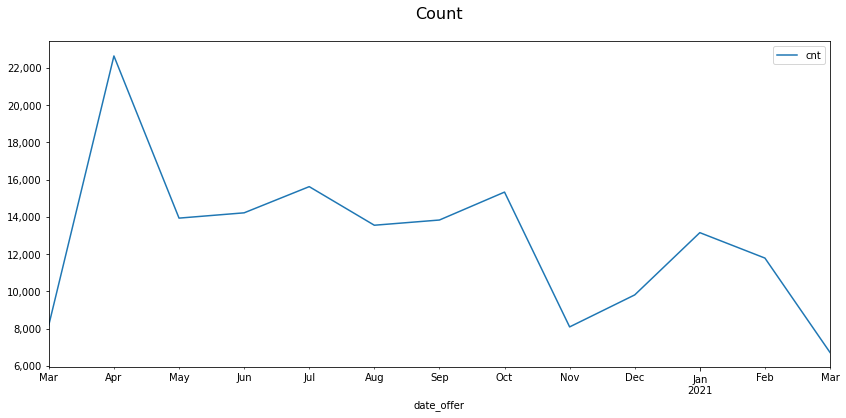

In [9]:
fig, ax = plt.subplots(figsize=(14,6))
_tmp = pd.DataFrame(
    {'date_offer':df.date_offer.dt.to_period("M"),
     'price':df.price})
_tmp.assign(cnt=1).groupby('date_offer').aggregate(cnt=('cnt','count')).plot(ax=ax)

plt.title('Count', y=1.05, fontsize = 16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}'.format(y))) 


## Data Split

* validation / out of time - last 10K,
* train / development - 40 K sample 
* test / out of sampple - 10 K sample 


In [17]:
import random

In [35]:
random.seed(666)

idx_valid = list(df.sort_values('date_offer').index[:10000])
idx_tt = (df.sort_values('date_offer').index[10000:])
idx_tt = random.sample(set(idx_tt), 50000)
idx_train = idx_tt[:40000]
idx_test = idx_tt[40000:]

df_train = df.loc[idx_train].reset_index(drop=True)
df_test = df.loc[idx_test].reset_index(drop=True)
df_valid = df.loc[idx_valid].reset_index(drop=True)



In [42]:
df_train.columns

Index(['_id', 'tracking_id', 'price', 'name', 'location', 'flat_size', 'rooms',
       'floor', 'producer_name', 'price_m2', 'market', 'building_type',
       'description', 'additional_info', 'number_of_floors',
       'building_material', 'year_of_building', 'property_form',
       'download_date', 'download_date_utc', 'offeror', 'date_created',
       'date_modified', 'GC_latitude', 'GC_longitude', 'GC_boundingbox',
       'GC_addr_road', 'GC_addr_neighbourhood', 'GC_addr_suburb',
       'GC_addr_city', 'GC_addr_state', 'GC_addr_postcode', 'GC_addr_country',
       'GC_addr_country_code', 'prediction', 'date_offer', 'date_offer_d',
       'date_offer_w', 'price_median_01w', 'price_median_02w',
       'price_median_03w', 'price_median_04w', 'price_median_08w',
       'price_median_12w', 'price_mean_01w', 'price_mean_02w',
       'price_mean_03w', 'price_mean_04w', 'price_mean_08w', 'price_mean_12w'],
      dtype='object')

In [54]:
drop_cols = ['tracking_id', 'price_m2', 'download_date',
             'download_date_utc', 'date_created', 'date_modified',
             'GC_boundingbox', 'GC_addr_road', 'GC_addr_city',
             'GC_addr_state', 'GC_addr_country', 'GC_addr_country_code',
             'prediction', 'date_offer_d', 'date_offer_w']

X_train = df_train.drop(columns=drop_cols)
X_train['split'] = 'train'
X_test = df_test.drop(columns=drop_cols)
X_test['split'] = 'test'
X_valid = df_valid.drop(columns=drop_cols)
X_valid['split'] = 'valid'

pd.concat([X_train, X_test, X_valid], axis=0)

,_id,price,name,location,flat_size,rooms,floor,producer_name,market,building_type,...,price_median_04w,price_median_08w,price_median_12w,price_mean_01w,price_mean_02w,price_mean_03w,price_mean_04w,price_mean_08w,price_mean_12w,split
0,oto_60770634_442000,442000,Ekskluzywnie urządzony z Klimatyzacją i Recepcją,"Warszawa, Ochota",37,2.0,NaN,otodom,wtorny,n/a,...,537500.0,562500.0,556750.0,643141.0,637567.0,621977.0,618483.0,618338.0,614645.0,train
1,oto_61377233_790204,790204,"80m2, III piętro, narożne, taras, Apartament 0%","Warszawa, Wola, Juliana Konstantego Ordona",79,4.0,3.0,otodom,pierwotny,apartamentowiec,...,586314.0,591335.0,586314.0,644000.0,611880.0,608475.0,615349.0,635298.0,613910.0,train
2,oto_60450614_1343160,1343160,Idealne na wynajem w topowej lokalizacji! Bez Pcc,"Warszawa, Śródmieście, Ordynacka",65,3.0,4.0,otodom,pierwotny,kamienica,...,559649.0,570080.0,562000.0,652782.0,623947.0,681847.0,664782.0,650802.0,633082.0,train
3,oto_61665838_399000,399000,Wola Park- Metro- Moczydło- Wysoki Standard-Ba...,"Warszawa, Wola, Czorsztyńska",34,1.0,3.0,otodom,wtorny,blok,...,596500.0,569175.0,569175.0,629975.0,641915.0,644443.0,634657.0,628175.0,631229.0,train
4,oto_60707254_576390,576390,"Kliknij tutaj! 2 pokoje SASKA KĘPA, KLIMATYZAC...","Warszawa, Praga-Południe, Saska Kępa, al. Alej...",46,2.0,9.0,otodom,wtorny,blok,...,545000.0,527500.0,528500.0,596045.0,588495.0,578327.0,581843.0,565634.0,564111.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,mor_2036113810_323000,323000,"Warszawa,","Warszawa,",33,2.0,2.0,morizon,wtorny,apartamentowiec,...,564500.0,564500.0,562900.0,603497.0,578968.0,584253.0,581241.0,614752.0,606669.0,valid
9996,gra_14452340_500000,500000,Mieszkanie Warszawa Śródmieście,"Warszawa, Śródmieście, mazowieckie",50,2.0,3.0,gratka,wtorny,n/a,...,772250.0,736789.0,692500.0,807528.0,777728.0,787239.0,793258.0,702526.0,688576.0,valid
9997,mor_2036113648_800000,800000,"Warszawa,","Warszawa,",70,2.0,1.0,morizon,wtorny,kamienica,...,772250.0,736789.0,692500.0,807528.0,777728.0,787239.0,793258.0,702526.0,688576.0,valid
9998,gra_15684420_640000,640000,Mieszkanie Warszawa Wawer,"Warszawa, Wawer, mazowieckie",85,3.0,2.0,gratka,wtorny,apartamentowiec,...,529250.0,529250.0,524534.0,565654.0,579007.0,567260.0,535570.0,530161.0,542544.0,valid


In [37]:
df_train.price

0         442000
1         790204
2        1343160
3         399000
4         576390
          ...   
39995     590000
39996     870000
39997    1386000
39998     519000
39999     625000
Name: price, Length: 40000, dtype: int64